In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.7f' % x)
# np.set_printoptions(suppress=True,
  #  formatter={'float_kind':'{:f}'.format})
# https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy/6811241#6811241
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
# https://stackoverflow.com/a/59974675/1114105
def rolling_window2d(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
# OK So first get the files up here. Epoch RR and Epoch Respiration Rate
rr = np.loadtxt("/content/drive/My Drive/BreathingSensing/record_206698/RR_interval_epoch.csv",delimiter=",",skiprows=1)
resp = np.loadtxt("/content/drive/My Drive/BreathingSensing/record_206698/outputData.csv",delimiter=",",skiprows=1)
rr = rr[:,:2]
resp = resp[:,[0,4]]
print(rr.shape)
print(resp.shape)
print(rr[0])

(38086, 2)
(28368, 2)
[1.60053082e+09 0.00000000e+00]


In [ ]:
# Next truncate RR Interval and respiration rate
# epoch times to integer (they have decimals originally) 
# and remove dupes for the same second for RR_Interval by averaging values
import pandas as pd
rr[:,0]= np.trunc(rr[:,0])
rr_trunc = rr
df_trunc =  pd.DataFrame({'time': rr_trunc[:, 0], 'rr': rr_trunc[:, 1]})
df_trunc_dedup = df_trunc.groupby('time').mean().reset_index()
rr_prep = df_trunc_dedup.to_numpy()
resp[:,0] = np.trunc(resp[:,0])
resp_prep = resp
print(rr_prep.shape)

(27604, 2)


In [ ]:
# Now combine RR-Interval and Respiration rate for timestamps where we have both values
# Get intersection
intersecting_times, rr_ind, resp_ind  = np.intersect1d(rr_prep[:,0], resp_prep[:,0], return_indices=True)
print(intersecting_times.shape)
vitals = []
for idx_rr, idx_resp in zip(rr_ind, resp_ind):
  vitals.append([rr_prep[idx_rr,0], rr_prep[idx_rr,1], resp_prep[idx_resp,1]])
vitals = np.array(vitals)
print(vitals.shape)

(27604,)
(27604, 3)


In [ ]:
# Check that the intersecting times do match
rr_prep[rr_ind].shape
resp_prep[resp_ind].shape
np.array_equal(rr_prep[rr_ind][:,0], resp_prep[resp_ind][:,0]) 

True

In [ ]:
# Is respiration data contiguous?
np.all(np.diff(resp_prep[:,0]) == 1) # Yes it is
import pandas as pd
# Join by epoch
rr_interval_df = pd.DataFrame(data=rr_prep, columns=["time","rr_interval"])
respiration_rate_df = pd.DataFrame(data=resp_prep, columns=["time","respiration_rate"])
merged_df = rr_interval_df.merge(respiration_rate_df,on='time',how='outer')
merged_df = merged_df.sort_values(by="time",inplace=False).reset_index(drop=True)
merged_df['rr_interval'].replace(0, np.NaN, inplace=True)
merged_df_last_non_nan = merged_df['rr_interval'].last_valid_index()
merged_df_first_non_nan = merged_df['rr_interval'].first_valid_index()
merged_df = merged_df[merged_df_first_non_nan:merged_df_last_non_nan+1]
interpolated = merged_df['rr_interval'].interpolate(limit=5)
merged_df['rr_interval'] = interpolated
merged_df = merged_df.reset_index(drop=True)

In [ ]:
is_NaN = merged_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = merged_df[row_has_NaN]
print(len(rows_with_NaN))
print(len(merged_df[merged_df['rr_interval'] == 0]))

0
0


In [ ]:
merged_df

,time,rr_interval,respiration_rate
0,1600530821.0000000,0.5722656,10.0000000
1,1600530822.0000000,0.2578125,10.0000000
2,1600530823.0000000,1.2304688,14.0000000
3,1600530824.0000000,0.7089844,23.0000000
4,1600530825.0000000,0.7812500,30.0000000
...,...,...,...
28353,1600559174.0000000,0.2734375,12.0000000
28354,1600559175.0000000,0.9960938,12.0000000
28355,1600559176.0000000,0.8554688,11.0000000
28356,1600559177.0000000,1.0839844,10.0000000


In [ ]:
breathing = merged_df['respiration_rate'].to_numpy()
rr = merged_df['rr_interval'].to_numpy()
rr.shape

(28358,)

In [ ]:
# Then, Calculate HRV using 2 minute windows
windows = rolling_window(rr, 120)
print(windows.shape)
hrvs = []
for window in windows:
  hrv = np.sqrt(np.mean(np.square(np.diff(window))))
  hrvs.append(hrv)
hrvs = np.array(hrvs)
print(hrvs.shape)
# print(hrv)


(28239, 120)
(28239,)


In [ ]:
# Delete first two mins of resp data
num_to_truncate = rr.shape[0] - hrvs.shape[0]

resp_final = breathing[num_to_truncate:]
hrv_resp = np.vstack((hrvs, resp_final)).T
print(hrv_resp.shape)
print(hrv_resp[0:10])

(28239, 2)
[[0.12370634 8.        ]
 [0.12030312 8.        ]
 [0.08090812 7.        ]
 [0.06529518 7.        ]
 [0.06502953 7.        ]
 [0.0650347  8.        ]
 [0.06396116 8.        ]
 [0.0621307  8.        ]
 [0.06786599 8.        ]
 [0.07012634 8.        ]]


In [ ]:
#Quantile RMSSD
high_anxiety_hrv_threshold = np.quantile(hrvs,.05)
high_anxiety_hrv_threshold

0.03256780847456941

In [ ]:
idx_high_anxiety = np.where(hrvs < high_anxiety_hrv_threshold)[0]
idx_normal_anxiety = np.where(hrvs >= high_anxiety_hrv_threshold)[0]
idx_normal_anxiety.shape[0] + idx_high_anxiety.shape[0]

28239

In [ ]:
# What does breathing look like?
respiration_during_low_hrv = resp_final[idx_high_anxiety]
respiration_during_normal_hrv = resp_final[idx_normal_anxiety]
respiration_during_normal_hrv_samples = np.random.choice(respiration_during_normal_hrv, size=respiration_during_low_hrv.shape[0], replace=False)

In [ ]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
t, p = ttest_ind(respiration_during_low_hrv, respiration_during_normal_hrv_samples, equal_var=False)
p

6.062690604613573e-12

In [ ]:
X = np.concatenate([respiration_during_normal_hrv_samples, respiration_during_low_hrv])
y = np.concatenate([np.zeros(respiration_during_normal_hrv_samples.shape[0]), np.ones(respiration_during_low_hrv.shape[0])])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train.reshape(-1,1), y_train)
clf.score(X_test.reshape(-1,1),y_test)

0.6051502145922747

In [ ]:
len(np.where(clf.predict(respiration_during_low_hrv.reshape(-1,1)) == 1)[0])


0

In [ ]:
respiration_during_normal_hrv.shape[0]

26827

In [ ]:
# Calculate Slopes

In [ ]:
slopes_resp = np.diff(resp_final)
# Look for size 50 windows with at least 8 increases and no decreases
# Window breathing slopes
breathing_slopes_windows = rolling_window(slopes_resp, 50)
hrv_windows = rolling_window(hrvs, 51)
breathing_windows = rolling_window(resp_final, 51)

In [ ]:
# accepts a size 50 array
def breathing_slope_pattern_exists(breathing_slope):
  unique, counts = np.unique(breathing_slope, return_counts=True)
  d = dict(zip(unique, counts))
  return 1 in d and d[1] >=8 and (-1 not in d or -1 in d and d[-1] < 1)

In [ ]:
breathing_windows_anx_pred = []
for idx, slope in enumerate(breathing_slopes_windows):
  isTarget = breathing_slope_pattern_exists(slope)
  if isTarget:
    breathing_windows_anx_pred.append(idx)

In [ ]:
# https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [ ]:
idx_high_anxiety_split = consecutive(idx_high_anxiety)

In [ ]:
# def count_bullseye_split(window_chunk, chunked_hrvs_high_anxiety):
#   for window_idx in window_chunk:
#     for hrv_idx in range(window_idx, window_idx + 52):
#       for chunk in chunked_hrvs_high_anxiety:
#         if hrv_idx in chunk:
#           return True
#   return False

def count_bullseye_split(window_idx, chunked_hrvs_high_anxiety):
  for hrv_idx in range(window_idx, window_idx + 52):
    for chunk in chunked_hrvs_high_anxiety:
      if hrv_idx in chunk:
        return True
  return False


In [ ]:
prediction_chunks = consecutive(breathing_windows_anx_pred)


In [ ]:
len(prediction_chunks)

18

In [ ]:
count_correct = 0
count_incorrect = 0
for candidate in breathing_windows_anx_pred:
  if count_bullseye_split(candidate, idx_high_anxiety_split):
    count_correct += 1
    # print(f"Index {candidate} correct")
  else:
    count_incorrect += 1
    # print(f"Index {candidate} incorrect")

print(f"Correct: {count_correct}, Incorrect:{count_incorrect}")
print(f"TPR is {count_correct / (count_correct + count_incorrect)}")

Correct: 36, Incorrect:99
TPR is 0.26666666666666666


In [ ]:
def count_low_hrv_points(breathing_window_idx):
  hrv_window = hrv_windows[breathing_window_idx] 
  return len(np.where(hrv_window < high_anxiety_hrv_threshold)[0]) 
  

In [ ]:
def calc_sensitivity_specificity(breathing_windows_anx_pred):
  count_bulls = 0
  count_fail = 0
  for idx in breathing_windows_anx_pred:
    low_hrv_pts = count_low_hrv_points(idx)
    if low_hrv_pts >= 30:
      count_bulls += 1
    else:
      count_fail += 1
    # print(f"idx: {idx}, points: {low_hrv_pts}")
  tpr = count_bulls / (count_fail + count_bulls)
  true_positives = count_bulls
  false_positives = count_fail

  count_bulls = 0
  count_fail = 0
  for idx in range(hrv_windows.shape[0]):
    low_hrv_pts = count_low_hrv_points(idx)
    if low_hrv_pts >= 30:
      count_bulls += 1
    else:
      count_fail += 1
  positives = count_bulls
  negatives = count_fail
  sensitivity = true_positives / positives
  specificity = (negatives - false_positives) / negatives

  return tpr, sensitivity, specificity

In [ ]:
calc_sensitivity_specificity(breathing_windows_anx_pred)

(0.2518518518518518, 0.0272654370489174, 0.9962512062950041)

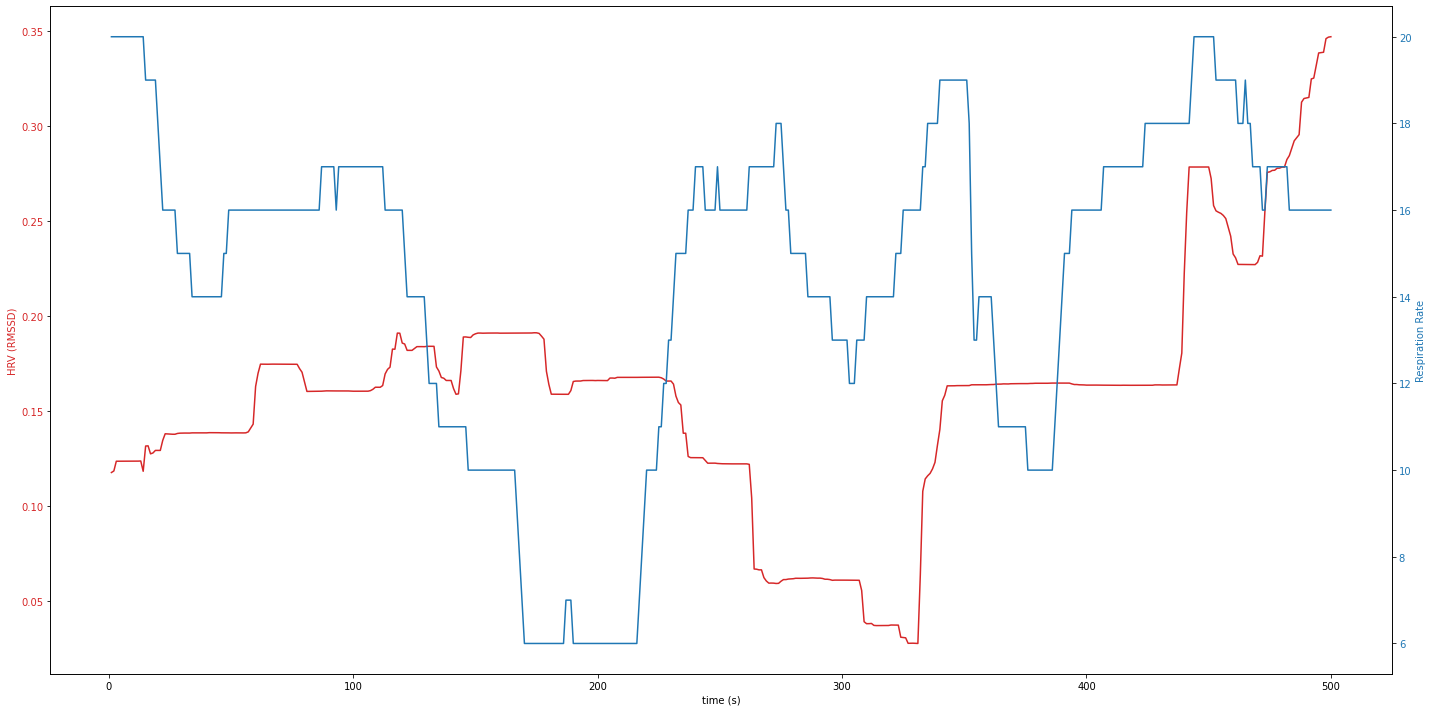

In [ ]:
# https://matplotlib.org/gallery/api/two_scales.html
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 10))
t = np.arange(1, 501, 1)
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('HRV (RMSSD)', color=color)
ax1.plot(t, hrv_resp[9400:9900,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Respiration Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(t, hrv_resp[9400:9900,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()